# This notebook is used with combined_data datafile

### LightFM Model for EBNeRD Dataset

Source: https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/lightfm_deep_dive.ipynb

### Shell

In [1]:
!pip install lightfm
!pip install git+https://github.com/microsoft/recommenders.git

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-cwgm8rum
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-cwgm8rum
  Resolved https://github.com/microsoft/recommenders.git to commit c2ea583d27bb1a4d58a09a1621d5ce95672ef1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import libraries

In [14]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
LightFM version: 1.17


### Defining variables

In [15]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

### Retrieving data

Note that only one of the following options needs to be run. You can either use MovieLens data, EBNeRD data (given that you have access to drive), or a number of rows from EBNeRD data. All subsequent operations are the same for all 3 options.

#### Retrieve data - EBNeRD

In [16]:
data = pd.read_csv("/content/drive/MyDrive/SW6/Colab notebooks/LightFM/combined_data_small.csv")
# quick look at the data
data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
3060022,651027,9768583,0,Transportmiddel
3216930,1871073,9752438,1,Politik
2703859,91216,9773275,0,Kendt
5209290,204900,9782133,0,Kriminalitet
5848055,1669055,9790713,0,Kendt


### Prepare data

In [17]:
dataset = Dataset()

In [18]:
dataset.fit(users=data['userID'],
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 18827, num_topics: 13018.


In [19]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

In [20]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

In [21]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (18827, 13018)
Shape of test interactions: (18827, 13018)


### Fit the LightFM model

In [22]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS,
                 learning_rate=LEARNING_RATE,
                 random_state=np.random.RandomState(SEED))

In [23]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### Model evaluation (AUC)

In [24]:
from lightfm.evaluation import auc_score

# Exclude interactions in the training set from the test set
test_interactions_excl_train = test_interactions - train_interactions.multiply(test_interactions)

# Calculate AUC score
with Timer() as auc_time:
    auc_scores = auc_score(model1, test_interactions=test_interactions_excl_train,
                           num_threads=NO_THREADS)

print(f"Took {auc_time.interval:.1f} seconds to calculate AUC scores.")

# Get the number of AUC scores and calculate the average AUC score
num_auc_scores = len(auc_scores)
average_auc_score = np.mean(auc_scores)

# Print the number of AUC scores and average AUC score
print("Number of AUC scores calculated:", num_auc_scores)
print("Average AUC score:", average_auc_score)

Took 45.7 seconds to calculate AUC scores.
Number of AUC scores calculated: 18814
Average AUC score: 0.60882086


### Track training and validation AUC score for each epoch to see convergence

In [ ]:
import matplotlib.pyplot as plt

# Store AUC scores for each epoch
train_auc_scores_per_epoch = []
test_auc_scores_per_epoch = []

for epoch in range(NO_EPOCHS):
    # Fit model for current epoch
    model1.fit_partial(interactions=train_interactions, epochs=1)

    # Calculate AUC score for current epoch
    train_auc_score_epoch = auc_score(model1, train_interactions,
                                num_threads=NO_THREADS)

    test_auc_score_epoch = auc_score(model1, test_interactions=test_interactions_excl_train,
                                num_threads=NO_THREADS)

    # Append AUC score to list
    train_auc_scores_per_epoch.append(np.mean(train_auc_score_epoch))
    test_auc_scores_per_epoch.append(np.mean(test_auc_score_epoch))

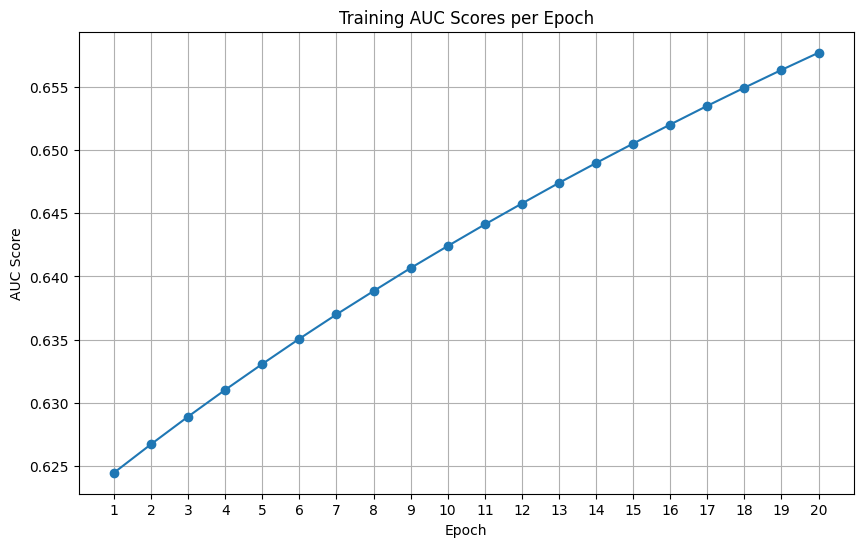

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), train_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Training AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

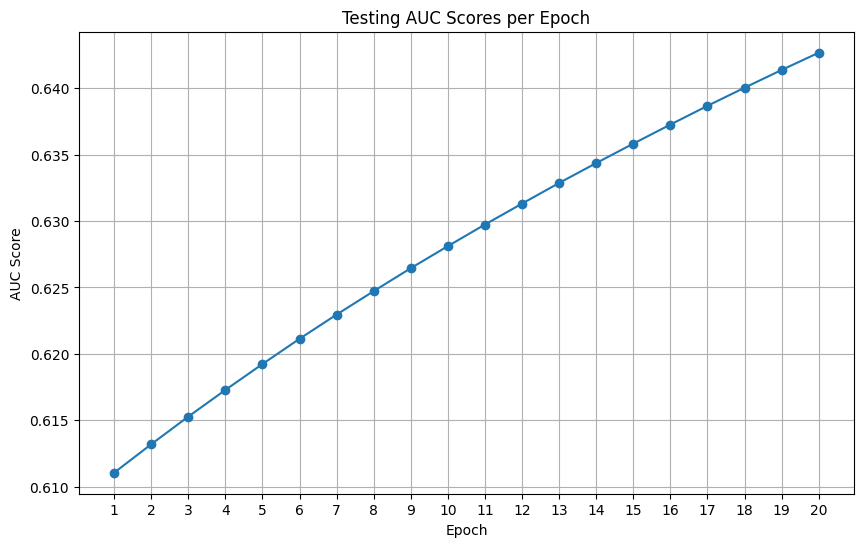

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), test_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Testing AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

### Export model

In [25]:
import joblib
joblib.dump(model1, 'lightfm_model_combined_data_small.joblib') # Use this one
#joblib.dump(model, 'lightfm_model.pkl')

['lightfm_model_combined_data_small.joblib']

## Old code not in use

### Prepare model evaluation data

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data,
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")
time_reco1 = test_time.interval

Took 14.5 seconds for prepare and predict test data.


In [ ]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
81504,918965,9788557,1.0
98769,1887792,9773045,5.0
82024,374121,9776449,20.0
60459,335429,9750898,10.0
86212,1639620,9748980,5.0


In [ ]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map,
                                              interactions=train_interactions,
                                              model=model1,
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

KeyboardInterrupt: 

In [ ]:
all_predictions.sample(5, random_state=SEED)

### Export all predictions

In [ ]:
# Define the file path where you want to save the predictions
predictions_file_path = 'model_predictions.csv'

# Export all predictions to a CSV file
all_predictions.to_csv(predictions_file_path, index=False)
print(f"All model predictions exported successfully to {predictions_file_path}")

### Model evaluation

In [ ]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df,
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions,
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions,
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval

print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}",
    sep='\n')

### Other utilities

#### Finding predictions for a user_id

In [ ]:
def get_top_predictions_for_user(user_id, all_predictions_df, k=10):
    user_predictions = all_predictions_df[all_predictions_df['userID'] == user_id]
    top_predictions = user_predictions.sort_values(by='prediction', ascending=False).head(k)
    return top_predictions

# Example usage: Get top predictions for user with ID
user_id = 743947
top_predictions_for_user = get_top_predictions_for_user(user_id, all_predictions)
print(f"Top {K} predictions for user {user_id}:")
print(top_predictions_for_user)

#### Exporting the model

In [ ]:
import joblib

# Define the file path where you want to save the model
model_file_path = 'lightfm_model_combined_data_demo.pkl'

# Export the model
joblib.dump(model1, model_file_path)
print(f"Model exported successfully to {model_file_path}")

Model exported successfully to lightfm_model_combined_data_demo.pkl


#### Importing the model

In [ ]:
# Define the file path from where you want to load the model
loaded_model = joblib.load(model_file_path)

# Check if the loaded object is an instance of the LightFM model class
if isinstance(loaded_model, LightFM):
    print("Model loaded successfully!")
else:
    print("Failed to load the model. Please check the file path or the model file.")


#### Preparing predictions with imported model

In [ ]:
with Timer() as test_time:
    loaded_model_predictions = prepare_all_predictions(data, uid_map, iid_map,
                                                       interactions=train_interactions,
                                                       model=loaded_model,
                                                       num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

#### Outputing prediction for specific user with imported model

In [ ]:
user_id = 626
top_predictions_for_user = get_top_predictions_for_user(user_id, loaded_model_predictions)
print(f"Top {K} predictions for user {user_id}:")
print(top_predictions_for_user)